# Step1: Seasonality. No External Dataset.

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
from datetime import datetime
from itertools import islice

from locationHelper import LocationHelper

## 1. Loading Data

### 1.1 Loading Compressed Parquet 

In [3]:
ba_ratings = pd.read_parquet('./data/BeerAdvocate/ratings_brotli.parquet')

### 1.2 Loading & Preprocessing From CSV

In [13]:

# Define the path to your .txt file
file_path = './data/BeerAdvocate/ratings.txt'

# Initialize lists to store the extracted line
styles = []
abvs = []
dates = []
user_ids = []
ratings = []

reviews = [] # True/False

appearances = []
aromas = []
palates = []
tastes = []
overalls = []
text_nb_words = []

total_lines = 0
if (file_path == './data/BeerAdvocate/ratings.txt') or (file_path == 'BeerAdvocate/ratings.txt'):
    total_lines = 151074576
else:
    total_lines = sum(1 for line in open(file_path, 'r', encoding='utf-8'))

line_count = 0
# Open the file and read line by line
with open(file_path, 'r', encoding='utf-8') as file:
    block = {}
    for line in tqdm(file, total=total_lines, desc="Processing lines"):
    # for line in tqdm(islice(file,500), total=total_lines, desc="Processing lines"):
        line_count += 1
        line = line.strip()
        if line == "":
            # End of a block
            if ('style' in block) and ('abv' in block) and ('date' in block) and ('user_id' in block) and ('rating' in block):   
                styles.append(str(block['style']))
                abvs.append(np.float32(block['abv']))
                dates.append(np.uint32(block['date']))
                user_ids.append(str(block['user_id']))
                ratings.append(np.float32(block['rating']))
                if ('review' in block) and ('appearance' in block) and ('aroma' in block) and ('palate' in block) and ('taste' in block) and ('overall' in block) and ('text' in block):
                    if block['review'] == 'True':
                        reviews.append(True)
                        appearances.append(np.float32(block['appearance']))
                        aromas.append(np.float32(block['aroma']))
                        palates.append(np.float32(block['palate']))
                        tastes.append(np.float32(block['taste']))
                        overalls.append(np.float32(block['overall']))
                        text_nb_words.append(np.uint16(len(block['text'].split())))
                    elif block['review'] == 'False':
                        reviews.append(False)
                        appearances.append(np.float32(np.nan))
                        aromas.append(np.float32(np.nan))
                        palates.append(np.float32(np.nan))
                        tastes.append(np.float32(np.nan))
                        overalls.append(np.float32(np.nan))
                        text_nb_words.append(np.uint16(0))
                    else:
                        print('Line', line_count, 'review is neither True nor False. The value is:', block['review'])
                else:
                    print('Line', line_count, 'is missing a review field')
            else:
                print('Line', line_count, 'is missing a main key field')
        else:
            try:
                key, value = line.split(': ', 1)
                block[key] = value
            except:
                print('Line', line_count, 'is missing a key or value')

Processing lines:  42%|████▏     | 63283099/151074576 [02:18<03:33, 410853.93it/s]

Line 63221506 is missing a key or value


Processing lines:  58%|█████▊    | 87098591/151074576 [03:33<02:06, 503875.03it/s]

Line 87010360 is missing a key or value


Processing lines: 100%|██████████| 151074576/151074576 [06:00<00:00, 418524.08it/s]


#### 1.2.1 Adding Time Data

In [ ]:
# Time
year_dates = [np.uint16(datetime.fromtimestamp(x).year) for x in dates]
month_dates = [np.uint8(datetime.fromtimestamp(x).month) for x in dates]
day_dates = [np.uint8(datetime.fromtimestamp(x).day) for x in dates]
# Mon = 0, Sun = 6
weekday_dates = [np.uint8(datetime.fromtimestamp(x).weekday()) for x in dates]

#### 1.2.2 Adding Location Data

In [47]:
ba_users = pd.read_csv("./data/BeerAdvocate/users.csv")
print(ba_users.head(3))
print(ba_users['location'].value_counts())


   nbr_ratings  nbr_reviews             user_id    user_name        joined  \
0         7820          465      nmann08.184925      nmann08  1.199704e+09   
1         2521         2504  stjamesgate.163714  StJamesGate  1.191838e+09   
2         1797         1143       mdagnew.19527      mdagnew  1.116410e+09   

                    location  
0  United States, Washington  
1    United States, New York  
2           Northern Ireland  
location
United States, California         11638
United States, Pennsylvania        8689
United States, New York            7432
United States, Illinois            6866
United States, Massachusetts       6658
                                  ...  
Marshall Islands                      1
Malvinas                              1
Mauritius                             1
British Indian Ocean Territory        1
Sint Maarten                          1
Name: count, Length: 194, dtype: int64


In [51]:
# Create a DataFrame from the lists
ba_ratings = pd.DataFrame({'Style' : styles, 
                           'ABV' : abvs,
                           'Dates': dates,
                           'Year': year_dates,
                           'Month': month_dates,
                           'Day': day_dates,
                           'Weekday': weekday_dates,
                           'User_ID': user_ids,
                           'Rating': ratings,
                           'Review': reviews, 
                           'Appearance': appearances, 
                           'Aroma': aromas, 
                           'Palate': palates, 
                           'Taste': tastes, 
                           'Overall': overalls, 
                           'Text_NB_Words': text_nb_words})

In [52]:
ba_ratings = ba_ratings.merge(ba_users.set_index('user_id')['location'], left_on='User_ID', right_index=True, how='left')
ba_ratings.rename(columns={'location': 'User_Location'}, inplace=True)

In [53]:
ba_ratings.head(3)

,Style,ABV,Dates,Year,Month,Day,Weekday,User_ID,Rating,Review,Appearance,Aroma,Palate,Taste,Overall,Text_NB_Words,User_Location
0,Euro Pale Lager,4.5,1440064800,2015,8,20,3,nmann08.184925,2.88,True,3.25,2.75,3.25,2.75,3.0,59,"United States, Washington"
1,English Pale Ale,4.5,1235127600,2009,2,20,4,stjamesgate.163714,3.67,True,3.00,3.50,3.50,4.00,3.5,47,"United States, New York"
2,English Pale Ale,4.5,1142247600,2006,3,13,0,mdagnew.19527,3.73,True,4.00,3.50,3.50,4.00,3.5,73,Northern Ireland


In [ ]:
# ba_ratings.to_parquet('./data/BeerAdvocate/ratings_brotli.parquet', compression='brotli',index=False)

In [ ]:
# from locationHelper import LocationHelper
# lh = LocationHelper(ba_ratings["User_Location"])

## 2. Worldwide Seasonality Of Ratings

In [61]:
# Function to compute confidence interval for a column
def compute_confidence_interval_margin_of_error(column, confidence_level=0.95):
    sample_mean = column.mean()
    std_err = stats.sem(column)
    degrees_freedom = len(column) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)
    margin_of_error = t_critical * std_err
    return margin_of_error

average_ratings = ba_ratings_fil.groupby('Month')['Rating'].mean()
std_average_ratings = ba_ratings_fil.groupby('Month')['Rating'].std()
ste_average_ratings = std_average_ratings / np.sqrt(ba_ratings_fil.groupby('Month')['Rating'].count())
# Compute confidence intervals for each column
confidence_intervals_margin_of_error = ba_ratings_fil.groupby('Month')['Rating'].apply(compute_confidence_interval_margin_of_error)

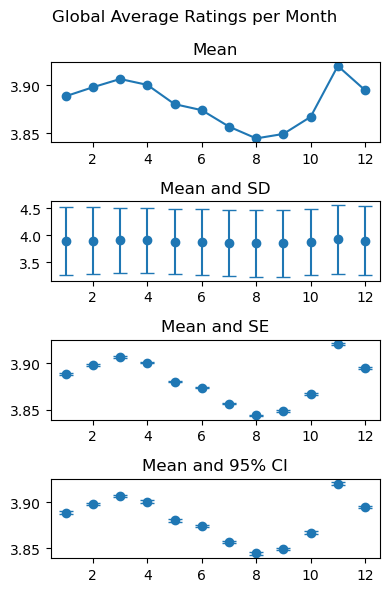

In [67]:
fig, axs = plt.subplots(4, 1, figsize=(4, 6))
plt.suptitle('Global Average Ratings per Month')
axs[0].plot(np.arange(12)+1, average_ratings, 'o-', label='Data')
axs[0].set_title('Mean')
axs[1].errorbar(x=np.arange(12)+1, y=average_ratings, yerr=st_average_ratings, fmt='o', capsize=5)
axs[1].set_title('Mean and SD')
axs[2].errorbar(x=np.arange(12)+1, y=average_ratings, yerr=ste_average_ratings, fmt='o', capsize=5)
axs[2].set_title('Mean and SE')
axs[3].errorbar(x=np.arange(12)+1, y=average_ratings, yerr=confidence_intervals_margin_of_error, fmt='o', capsize=5)
axs[3].set_title('Mean and 95% CI')
plt.tight_layout()
plt.show()

## Testing

<Axes: title={'center': 'Global Average Aroma per Month'}, xlabel='Month', ylabel='Aroma'>

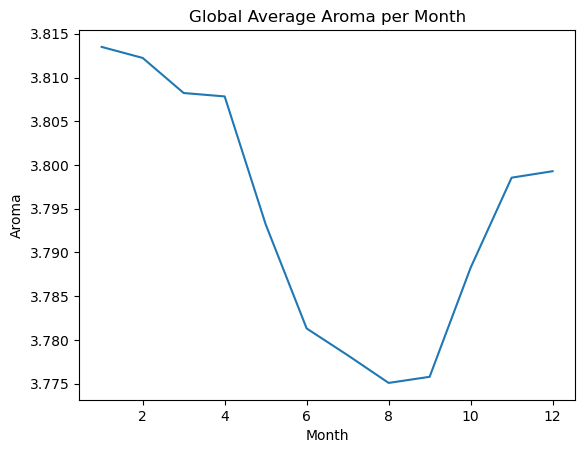

In [76]:
ba_ratings.groupby('Month')['Aroma'].mean().plot(title='Global Average Aroma per Month', ylabel='Aroma', xlabel='Month')

<Axes: title={'center': 'Global Average Aroma per Month'}, xlabel='Month', ylabel='Aroma'>

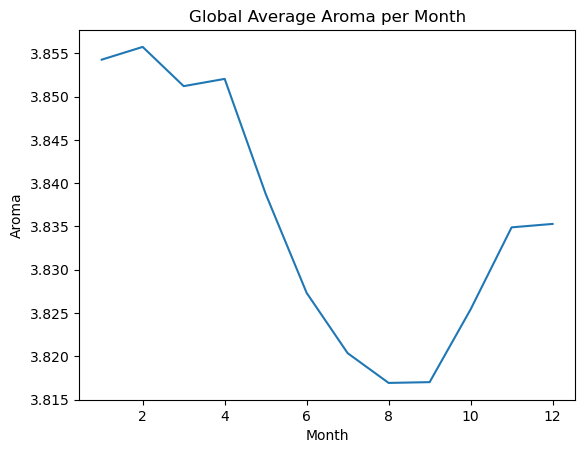

In [26]:
ba_ratings.groupby('Month')['Taste'].mean().plot(title='Global Average Aroma per Month', ylabel='Aroma', xlabel='Month')

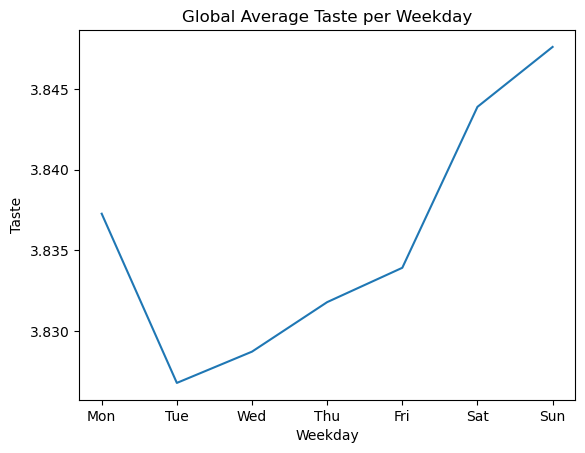

In [77]:
ax = ba_ratings.groupby('Weekday')['Taste'].mean().plot(title='Global Average Taste per Weekday', ylabel='Taste', xlabel='Weekday')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

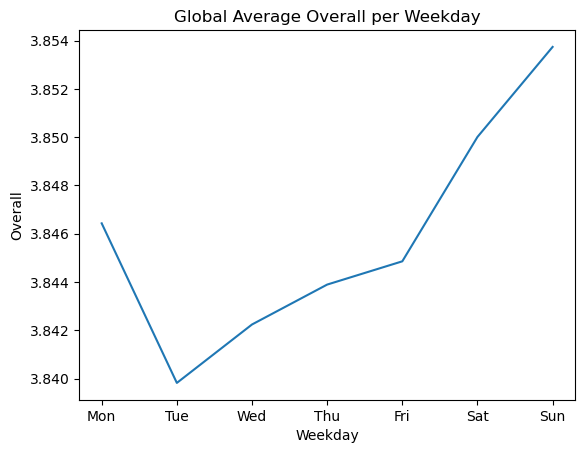

In [78]:
ax = ba_ratings.groupby('Weekday')['Overall'].mean().plot(title='Global Average Overall per Weekday', ylabel='Overall', xlabel='Weekday')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

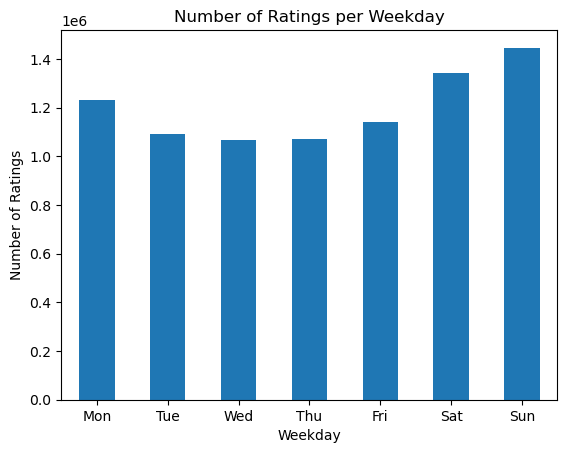

In [3]:
# Plot the count of ratings per weekday
weekday_counts = ba_ratings['Weekday'].value_counts().sort_index()
ax = weekday_counts.plot(kind='bar', title='Number of Ratings per Weekday', ylabel='Number of Ratings', xlabel='Weekday')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

<Axes: title={'center': 'Global Average Ratings per Day'}, xlabel='Day', ylabel='Rating'>

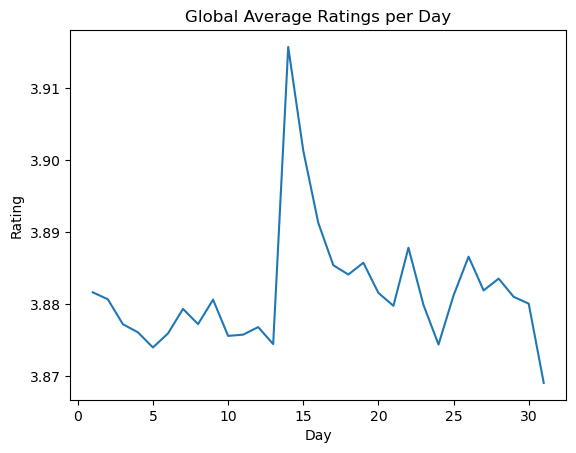

In [ ]:
# In this graph the weekdays of the different months do not align
# Why is it that we can obersve a peak around day 15?
# Is this just noise?
ba_ratings.groupby('Day')['Rating'].mean().plot(title='Global Average Ratings per Day', ylabel='Rating', xlabel='Day')

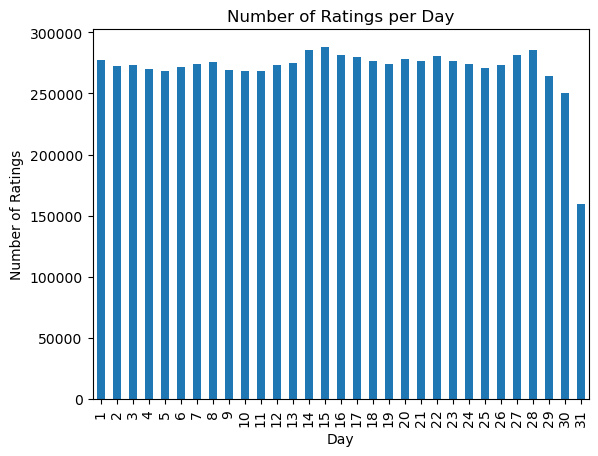

In [79]:
# Plot the count of ratings per day
day_counts = ba_ratings['Day'].value_counts().sort_index()
ax = day_counts.plot(kind='bar', title='Number of Ratings per Day', ylabel='Number of Ratings', xlabel='Day')
plt.show()

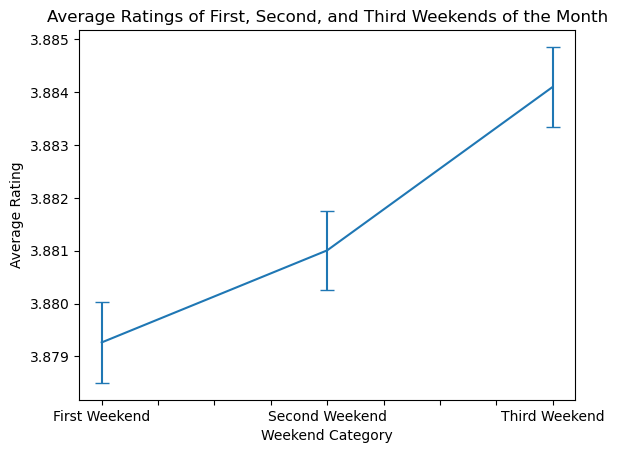

In [84]:
# Function to determine if a date is in the first, second, or third weekend of the month
def get_weekend_category(day, weekday):
    if weekday == 5:  # Saturday
        if 1 <= day <= 7:
            return 'First Weekend'
        elif 8 <= day <= 14:
            return 'Second Weekend'
        elif 15 <= day <= 21:
            return 'Third Weekend'
    elif weekday == 6:  # Sunday
        if 2 <= day <= 8:
            return 'First Weekend'
        elif 9 <= day <= 15:
            return 'Second Weekend'
        elif 16 <= day <= 22:
            return 'Third Weekend'
    return 'Other'

# Apply the function to the DataFrame
ba_ratings['Weekend_Category'] = [get_weekend_category(day, weekday) for day, weekday in zip(ba_ratings['Day'], ba_ratings['Weekday'])]

# Filter out 'Other' category
weekend_ratings = ba_ratings[ba_ratings['Weekend_Category'] != 'Other']

# Group by Weekend_Category and calculate the mean ratings
avg_weekend_ratings = weekend_ratings.groupby('Weekend_Category')['Rating'].mean()

# Calculate the standard error for each weekend category
std_error_weekend_ratings = weekend_ratings.groupby('Weekend_Category')['Rating'].sem()

# Plot the results with error bars
avg_weekend_ratings.plot(yerr=std_error_weekend_ratings, capsize=5, title='Average Ratings of First, Second, and Third Weekends of the Month', ylabel='Average Rating', xlabel='Weekend Category')
plt.show()

In [85]:
ba_ratings['Style'].value_counts()

Style
American IPA                        997814
American Double / Imperial IPA      739982
American Double / Imperial Stout    500265
American Pale Ale (APA)             388139
Saison / Farmhouse Ale              301953
                                     ...  
English Pale Mild Ale                 2443
Roggenbier                            1911
Faro                                  1796
Kvass                                  814
Happoshu                               627
Name: count, Length: 104, dtype: int64

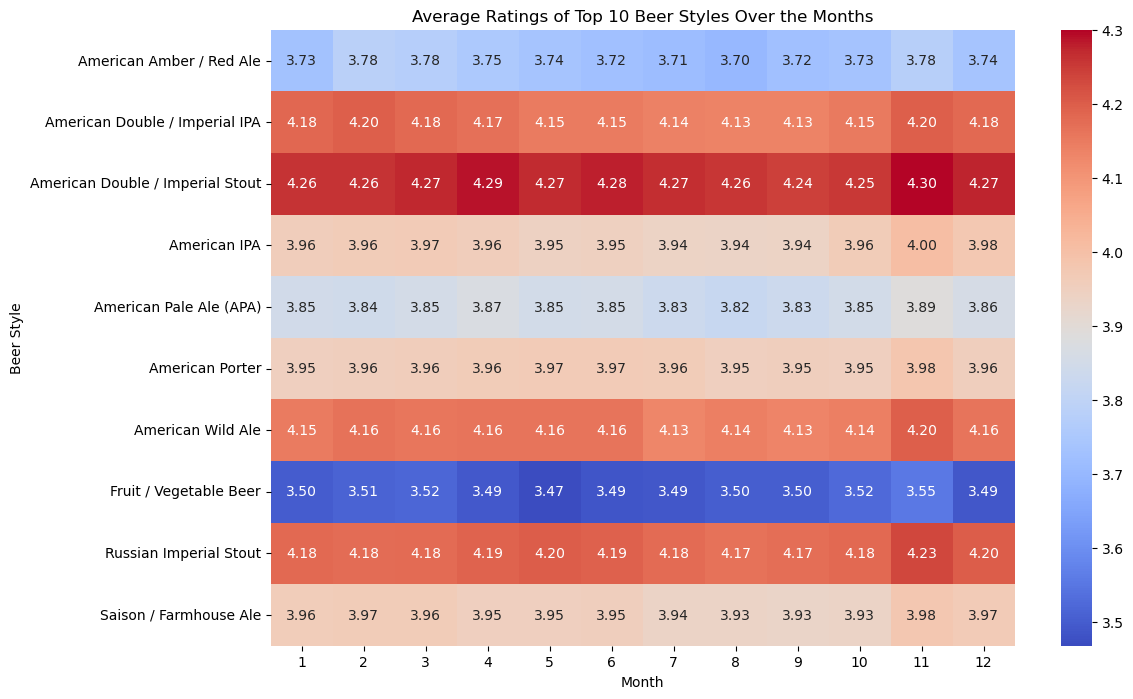

In [20]:
# Get the 10 most popular beer styles
top_styles = ba_ratings['Style'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 styles
top_styles_ratings = ba_ratings[ba_ratings['Style'].isin(top_styles)]

# Group by Style and Month, then calculate the mean rating
style_month_avg_ratings = top_styles_ratings.groupby(['Style', 'Month'])['Rating'].mean().unstack()

# Plot the results
plt.figure(figsize=(12, 8))
sns.heatmap(style_month_avg_ratings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Ratings of Top 10 Beer Styles Over the Months')
plt.xlabel('Month')
plt.ylabel('Beer Style')
plt.show()

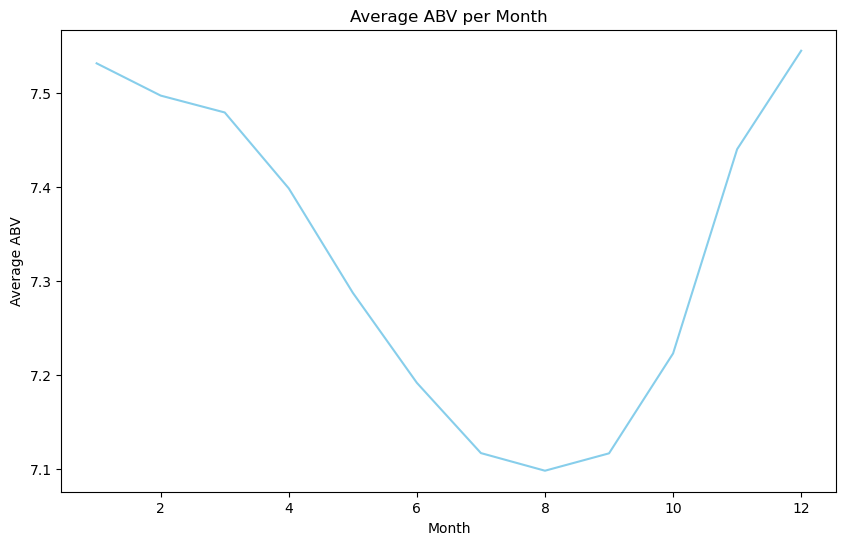

In [4]:
# Group by Month and calculate the mean ABV
average_abv_per_month = ba_ratings.groupby('Month')['ABV'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
average_abv_per_month.plot(color='skyblue')
plt.title('Average ABV per Month')
plt.xlabel('Month')
plt.ylabel('Average ABV')
plt.xticks(rotation=0)
plt.show()

In [91]:
import scipy.stats as stats

# Example data
group1 = [10, 12, 14, 16, 18]
group2 = [20, 22, 24, 26, 28]
group3 = [30, 32, 34, 36, 38]

# Perform Levene's test
# stat, p_value = stats.levene(group1, group2, group3)
stat, p_value = stats.levene(weekday_counts, average_abv_per_month)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Levene's test statistic: 14.225953748997462, p-value: 0.001521416849208968


array([726054, 650727, 721783, 662373, 713235, 712153, 748037, 697636,
       622078, 647594, 751637, 739725])

In [6]:
average_abv_per_month

Month
1     7.531959
2     7.497626
3     7.479663
4     7.398861
5     7.287710
6     7.191877
7     7.117094
8     7.098323
9     7.116822
10    7.223150
11    7.440543
12    7.545385
Name: ABV, dtype: float32

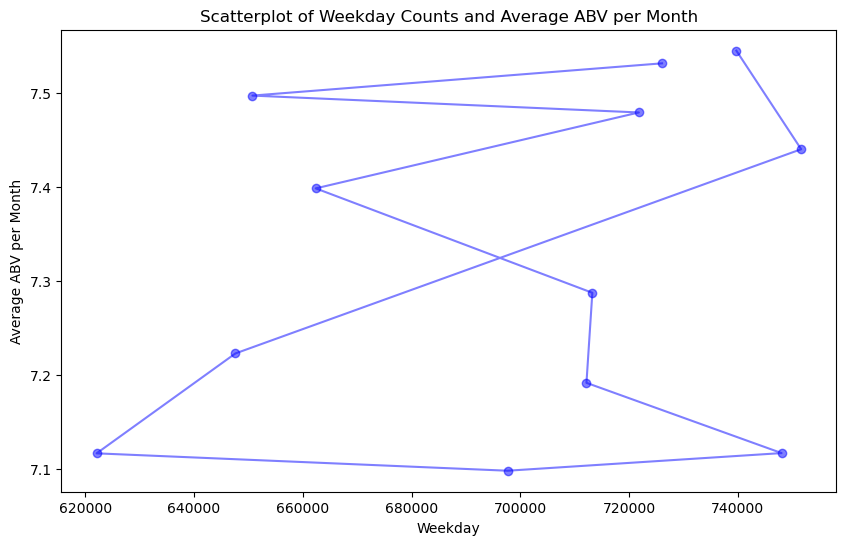

In [15]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(ba_ratings['Month'].value_counts().sort_index().values, average_abv_per_month.values, color='blue', alpha=0.5, linestyle='-', marker='o')

# plt.scatter(ba_ratings['Month'].value_counts().sort_index().values, average_abv_per_month.values, color='blue', alpha=0.5)

# Add titles and labels
plt.title('Scatterplot of Weekday Counts and Average ABV per Month')
plt.xlabel('Weekday')
plt.ylabel('Average ABV per Month')

# Set x-ticks to represent weekdays
# plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

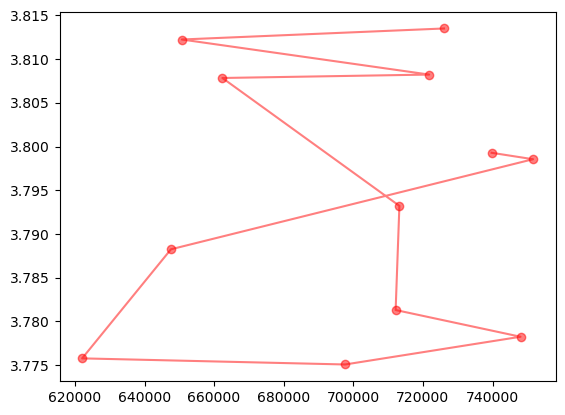

In [16]:
plt.plot(ba_ratings['Month'].value_counts().sort_index().values, ba_ratings.groupby('Month')['Aroma'].mean().values, color='red', alpha=0.5, linestyle='-', marker='o')


In [29]:
import scipy.stats as stats

# Perform Levene's test
# stat, p_value = stats.levene(group1, group2, group3)
stat, p_value = stats.levene(ba_ratings['Month'].value_counts().sort_index().values, ba_ratings.groupby('Month')['Aroma'].mean().values, average_abv_per_month.values)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Levene's test statistic: 17.060291535363632, p-value: 8.172607078594972e-06


In [34]:
import scipy.stats as stats

# Rating	Review	Appearance	Aroma	Palate	Taste	Overall

# Perform Levene's test
# stat, p_value = stats.levene(group1, group2, group3)
stat, p_value = stats.levene(ba_ratings.groupby('Month')['Aroma'].mean().values, ba_ratings.groupby('Month')['Appearance'].mean().values)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Levene's test statistic: 0.0768295314979814, p-value: 0.7842286190835512


In [21]:
style_month_avg_ratings

Month,1,2,3,4,5,6,7,8,9,10,11,12
Style,,,,,,,,,,,,
American Amber / Red Ale,3.730093,3.784111,3.775329,3.751620,3.735971,3.721929,3.713410,3.700588,3.723255,3.733356,3.777247,3.735504
American Double / Imperial IPA,4.184217,4.196383,4.182164,4.167306,4.150646,4.148255,4.138757,4.134595,4.134738,4.150931,4.196216,4.183166
American Double / Imperial Stout,4.258426,4.259642,4.272370,4.289689,4.269865,4.277863,4.265026,4.255953,4.242768,4.251761,4.300149,4.274334
American IPA,3.957294,3.964235,3.967747,3.955896,3.945700,3.948734,3.939280,3.936032,3.937537,3.964289,4.004547,3.977558
American Pale Ale (APA),3.845701,3.844100,3.852600,3.873852,3.851669,3.854525,3.834827,3.820200,3.833192,3.851238,3.889389,3.858392
American Porter,3.952453,3.955644,3.958303,3.963779,3.968455,3.967063,3.963611,3.952482,3.953262,3.949595,3.982317,3.955050
American Wild Ale,4.147779,4.163909,4.158947,4.161806,4.160818,4.160553,4.130823,4.143673,4.132601,4.142045,4.197171,4.163689
Fruit / Vegetable Beer,3.498594,3.512102,3.519712,3.491184,3.468430,3.485853,3.488826,3.501567,3.502704,3.524027,3.553655,3.490733
Russian Imperial Stout,4.180156,4.176028,4.178872,4.190867,4.201559,4.194333,4.177884,4.166674,4.170434,4.180457,4.233942,4.199449


In [24]:
style_month_avg_ratings.iloc[0].values

array([3.7300932, 3.7841108, 3.7753286, 3.7516196, 3.7359712, 3.7219288,
       3.71341  , 3.7005882, 3.723255 , 3.7333565, 3.7772472, 3.735504 ],
      dtype=float32)

In [23]:
import scipy.stats as stats

# Perform Levene's test
# stat, p_value = stats.levene(group1, group2, group3)
stat, p_value = stats.levene(style_month_avg_ratings.iloc[0].values, style_month_avg_ratings.iloc[1].values, style_month_avg_ratings.iloc[2].values, style_month_avg_ratings.iloc[3].values, style_month_avg_ratings.iloc[4].values, style_month_avg_ratings.iloc[5].values, style_month_avg_ratings.iloc[6].values, style_month_avg_ratings.iloc[7].values, style_month_avg_ratings.iloc[8].values, style_month_avg_ratings.iloc[9].values)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Levene's test statistic: 1.2181098601067926, p-value: 0.2912573640983057


In [4]:
ba_ratings.head(3)

,Style,ABV,Dates,Year,Month,Day,Weekday,User_ID,Rating,Review,Appearance,Aroma,Palate,Taste,Overall,Text_NB_Words,User_Location
0,Euro Pale Lager,4.5,1440064800,2015,8,20,3,nmann08.184925,2.88,True,3.25,2.75,3.25,2.75,3.0,59,"United States, Washington"
1,English Pale Ale,4.5,1235127600,2009,2,20,4,stjamesgate.163714,3.67,True,3.00,3.50,3.50,4.00,3.5,47,"United States, New York"
2,English Pale Ale,4.5,1142247600,2006,3,13,0,mdagnew.19527,3.73,True,4.00,3.50,3.50,4.00,3.5,73,Northern Ireland


In [6]:
ba_ratings[ba_ratings['Review'] == True].head(3)

,Style,ABV,Dates,Year,Month,Day,Weekday,User_ID,Rating,Review,Appearance,Aroma,Palate,Taste,Overall,Text_NB_Words,User_Location
0,Euro Pale Lager,4.5,1440064800,2015,8,20,3,nmann08.184925,2.88,True,3.25,2.75,3.25,2.75,3.0,59,"United States, Washington"
1,English Pale Ale,4.5,1235127600,2009,2,20,4,stjamesgate.163714,3.67,True,3.00,3.50,3.50,4.00,3.5,47,"United States, New York"
2,English Pale Ale,4.5,1142247600,2006,3,13,0,mdagnew.19527,3.73,True,4.00,3.50,3.50,4.00,3.5,73,Northern Ireland


<Axes: >

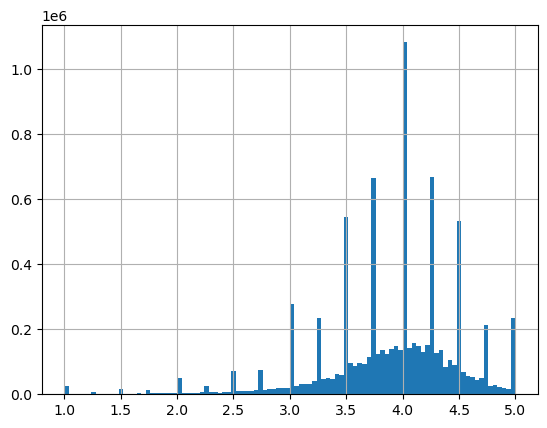

In [10]:
ba_ratings['Rating'].hist(bins=100)

In [20]:
test_sub = ba_ratings[ba_ratings['Review'] == False]

<Axes: >

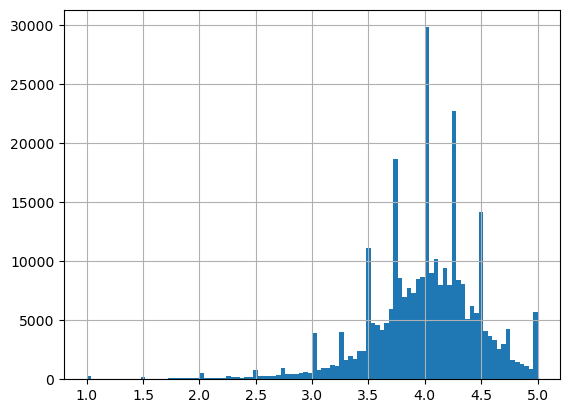

In [43]:
test_sub[test_sub['Year'] == 2017]['Rating'].hist(bins=100)

<Axes: >

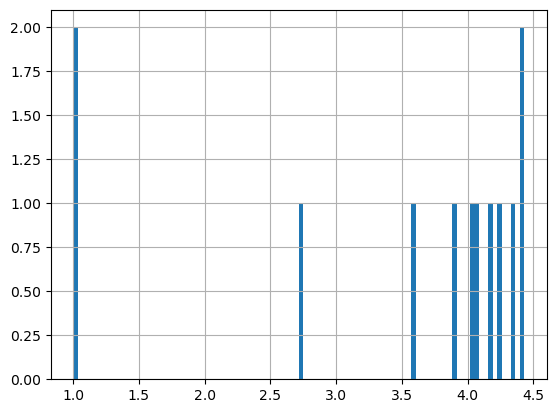

In [ ]:
test_sub[test_sub['Year'] == 200]['Rating'].hist(bins=100)

<Axes: >

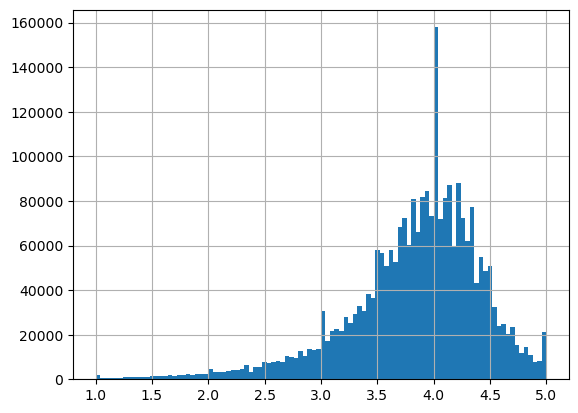

In [14]:
ba_ratings[ba_ratings['Review'] == True]['Rating'].hist(bins=100)

<Axes: >

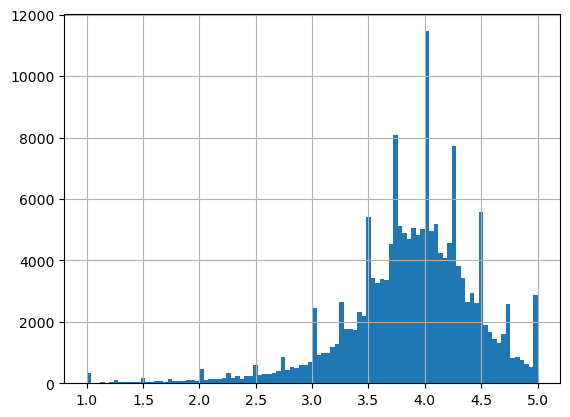

In [56]:
ba_ratings[(ba_ratings['Review'] == True) & (ba_ratings['Year'] == 2014)]['Rating'].hist(bins=100)

In [12]:
np.arange(1, 5.25, 0.25)

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [ ]:
# Get the 10 most popular beer styles
top_styles = ba_ratings['Style'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 styles
top_styles_ratings = ba_ratings[ba_ratings['Style'].isin(top_styles)]

# Group by Style and Month, then calculate the mean rating
style_month_avg_ratings = top_styles_ratings.groupby(['Style', 'Month'])['Rating'].mean().unstack()

# Plot the results
plt.figure(figsize=(12, 8))
sns.heatmap(style_month_avg_ratings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Ratings of Top 10 Beer Styles Over the Months')
plt.xlabel('Month')
plt.ylabel('Beer Style')
plt.show()

<Axes: title={'center': 'Global Average Ratings per Month'}, xlabel='Month', ylabel='Rating'>

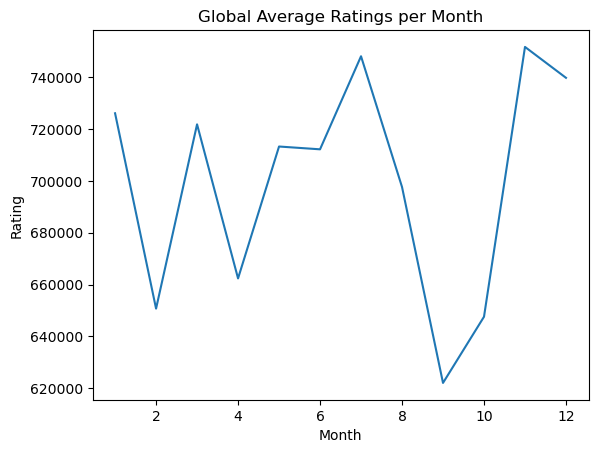

In [59]:
ba_ratings.groupby('Month')['Rating'].count().plot(title='Global Average Ratings per Month', ylabel='Rating', xlabel='Month')

In [63]:
ba_ratings.head(3)

,Style,ABV,Dates,Year,Month,Day,Weekday,User_ID,Rating,Review,Appearance,Aroma,Palate,Taste,Overall,Text_NB_Words,User_Location
0,Euro Pale Lager,4.5,1440064800,2015,8,20,3,nmann08.184925,2.88,True,3.25,2.75,3.25,2.75,3.0,59,"United States, Washington"
1,English Pale Ale,4.5,1235127600,2009,2,20,4,stjamesgate.163714,3.67,True,3.00,3.50,3.50,4.00,3.5,47,"United States, New York"
2,English Pale Ale,4.5,1142247600,2006,3,13,0,mdagnew.19527,3.73,True,4.00,3.50,3.50,4.00,3.5,73,Northern Ireland


<Axes: title={'center': 'Global Average Rating per Month'}, xlabel='Month', ylabel='Rating'>

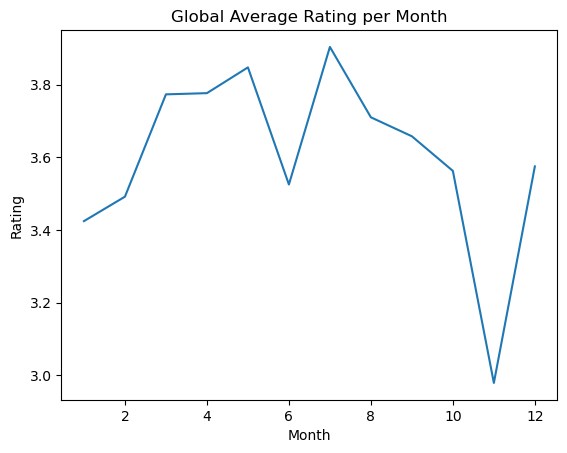

In [ ]:
ba_ratings[ba_ratings['User_Location'] == 'Argentina'].groupby('Month')['Rating'].mean().plot(title='Global Average Rating per Month', ylabel='Rating', xlabel='Month')

<Axes: title={'center': 'Global Average Rating per Month'}, xlabel='Month', ylabel='Rating'>

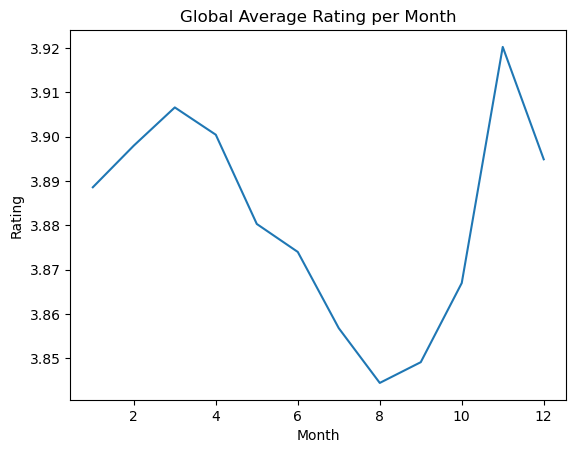

In [65]:
ba_ratings.groupby('Month')['Rating'].mean().plot(title='Global Average Rating per Month', ylabel='Rating', xlabel='Month')

In [77]:
ba_ratings['Style'].value_counts()

Style
American IPA                        997814
American Double / Imperial IPA      739982
American Double / Imperial Stout    500265
American Pale Ale (APA)             388139
Saison / Farmhouse Ale              301953
                                     ...  
English Pale Mild Ale                 2443
Roggenbier                            1911
Faro                                  1796
Kvass                                  814
Happoshu                               627
Name: count, Length: 104, dtype: int64

<Axes: title={'center': 'Global Average Rating per Month'}, xlabel='Month', ylabel='Rating'>

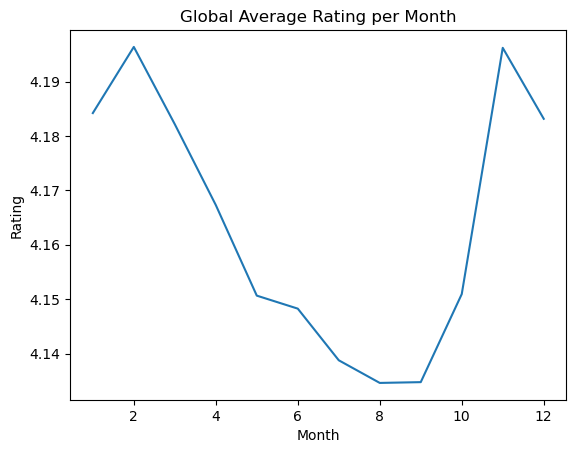

In [80]:
ba_ratings[ba_ratings['Style'] == 'American Double / Imperial IPA'].groupby('Month')['Rating'].mean().plot(title='Global Average Rating per Month', ylabel='Rating', xlabel='Month')